# Example 2: Nonlinear Time-History Analysis of MDOF Systems using the "modeller" Class

## Introduction

This Jupyter Notebook provides a structured workflow for performing nonlinear time-history analyses (NLTHA) on multi-degree-of-freedom (MDOF) structural models. By combining functions for MDOF modeling and dynamic analysis, the notebook enables the setup, execution, and post-processing of structural responses under earthquake loading.

The main goals of this notebook:

1. **Calibrate MDOF models based on single-degree-of-freedom (SDOF) oscillator capacity**: Calibrate storey-based force-deformation relationships using SDOF capacity curve definition (spectral displacement-spectral acceleration) based on the methodology of Lu et al. (2020) and other modifications to account for distinct response typologies (i.e., bilinear, trilinear and quadrilinear backbone definitions)

2. **Compile and construct MDOF Models in OpenSees**: Define and assemble MDOF models by specifying essential structural properties, including:
   - Mass, heights, fundamental period, etc.
   - Nonlinear response characteristics at each degree of freedom

3. **Run Nonlinear Time-History Analysis (NLTHA) in OpenSees**: Simulate the dynamic response of MDOF structures under time-dependent inputs, such as ground motion records, to realistically assess structural behavior and response metrics (e.g., peak storey drifts, peak floor accelerations) under loading conditions and extract critical response metrics and model information.

The notebook provides a step-by-step guide, covering each phase from MDOF model calibration, setup to input parameter configuration, analysis execution, and detailed results extraction. Users should have some familiarity with python scripts, structural dynamics and computational modeling to fully benefit from this material.

---

## Prerequisites

To run this notebook successfully, the following "non-native" Python packages are required:
-  openseespy: A Python library for performing finite element analysis based on the OpenSees framework.
    - Reference: https://openseespydoc.readthedocs.io/en/latest/

---

## References

[1] Lu X, McKenna F, Cheng Q, Xu Z, Zeng X, Mahin SA. An open-source framework for regional earthquake loss estimation using the city-scale nonlinear time history analysis. Earthquake Spectra. 2020;36(2):806-831. doi:10.1177/8755293019891724

## Initialize Libraries ##

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start = time.time()

# Set paths
vmtk = os.path.abspath(os.path.join("..",".."))
sys.path.append(vmtk)
os.chdir(os.path.join(vmtk,'src'))

# Import the classes necessary for structural analysis
from src.calibration import calibrate_model
from src.modeller    import modeller
from src.utilities   import sorted_alphanumeric, import_from_pkl, export_to_pkl
from src.units       import units

## Define Plotting Constants ##

In [3]:
FONTSIZE_1 = 16
FONTSIZE_2 = 14
FONTSIZE_3 = 12

LINEWIDTH_1= 3
LINEWIDTH_2= 2
LINEWIDTH_3 = 1

RESOLUTION = 500

MARKER_SIZE_1 = 100
MARKER_SIZE_2 = 60
MARKER_SIZE_3 = 10

COLOR = "#399283"

## Define Directories ##

In [5]:
# Define the directory of the capacities
capacity_directory = f'{vmtk}/demos/in/capacity'          

# Define the directory of the ground-motion records
gm_directory  = f'{vmtk}/demos/in/records'            

# Define the main output directory
nltha_directory = f'{vmtk}/demos/out/nltha'  
if not os.path.exists(f'{nltha_directory}'):
    os.makedirs(f'{nltha_directory}')

## Required Input Parameters

In [ ]:
# Number of storeys
number_storeys = 2
# Relative floor heights list
floor_heights = [2.80, 2.80]
# First-mode based participation factor
gamma = 1.33
# SDOF capacity (First row are Spectral Displacement [m] values - Second row are Spectral Acceleration [g] values)
sdof_capacity = np.array([[0.00060789, 0.00486316, 0.02420000, 0.04353684], 
                          [0.10315200, 0.20630401, 0.12378241, 0.12502023]]).T
# SDOF period
sdof_period = 0.154
# Frame flag
isFrame = False
# Soft-storey mechanism flag
isSOS = False
# Degradation
sdof_degradation = True
# Inherent damping 
sdof_damping = 0.05

# Analysis

## Analysis Part 1: Calibrate MDOF Model based on SDOF Capacity Definition ##

#### The calibration function (calibrate_model) requires six input arguments:
1. Number of storeys
2. First-mode transformation factor (gamma)
3. The capacity array of the single degree-of-freedom oscillator
4. The fundamental period of the single degree-of-freedom oscillator
5. Boolean flag whether the lateral load-resisting system for the considered building class is moment-resisting frames (or not)
6. Boolean flag whether the building class expects a soft-storey mechanism to be activated (or not)

#### The calibration function (calibrate_model) returns four output variables:
1. The floor mass array to be assigned to the MDOF model generator (floor_masses)
2. The storey deformation (in m) capacity to be assigned to the MDOF model generator (storey_disps)
3. The acceleration capacity (in g) to be assigned to the MDOF model generator (storey_forces)
4. The considered mode shape (mdof_phi)

The mass of each floor (in tonnes): [0.5979496788391293, 0.448462259129347]
The first-mode shape used for calibration: [0.65138782 1.        ]


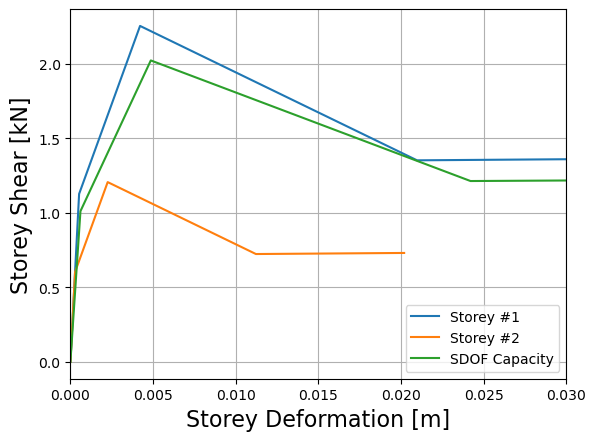

In [9]:
# Calibrate the model using the Lu et al. (2020) method
floor_masses, storey_disps, storey_forces, mdof_phi = calibrate_model(number_storeys, gamma, sdof_capacity, sdof_period, isFrame, isSOS)

print('The mass of each floor (in tonnes):', floor_masses)
print('The first-mode shape used for calibration:', mdof_phi)

# Plot the capacities to visualise the outcome of the calibration
for i in range(storey_disps.shape[0]):
   plt.plot(np.concatenate(([0.0], storey_disps[i,:])), np.concatenate(([0.0], storey_forces[i,:]*9.81)), label = f'Storey #{i+1}')
plt.plot(np.concatenate(([0.0], sdof_capacity[:,0])), np.concatenate(([0.0], sdof_capacity[:,1]*9.81)), label = f'SDOF Capacity')
plt.xlabel('Storey Deformation [m]', fontsize= FONTSIZE_1)
plt.ylabel('Storey Shear [kN]', fontsize = FONTSIZE_1)
plt.legend(loc = 'lower right')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xlim([0.00, 0.03])
plt.show()

## Analysis Part 2: Setting Up Analysis and Running

In [11]:
# Initialise MDOF storage lists
mdof_coll_index_list = []               # List for collapse index
mdof_peak_disp_list  = []               # List for peak floor displacement (returns all peak values along the building height)
mdof_peak_drift_list = []               # List for peak storey drift (returns all peak values along the building height)
mdof_peak_accel_list = []               # List for peak floor acceleration (returns all peak values along the building height)
mdof_max_peak_drift_list = []           # List for maximum peak storey drift (returns the maximum value) 
mdof_max_peak_drift_dir_list = []       # List for maximum peak storey drift directions
mdof_max_peak_drift_loc_list = []       # List for maximum peak storey drift locations
mdof_max_peak_accel_list = []           # List for maximum peak floor acceleration (returns the maximum value)
mdof_max_peak_accel_dir_list = []       # List for maximum peak floor acceleration directions 
mdof_max_peak_accel_loc_list = []       # List for maximum peak floor acceleration locations 

# Define directory for temporary analysis outputs
temp_nrha_outdir = f'{nltha_directory}/temp'
if not os.path.exists(f'{temp_nrha_outdir}'):
    os.makedirs(f'{temp_nrha_outdir}')

============== ANALYSING: 1 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


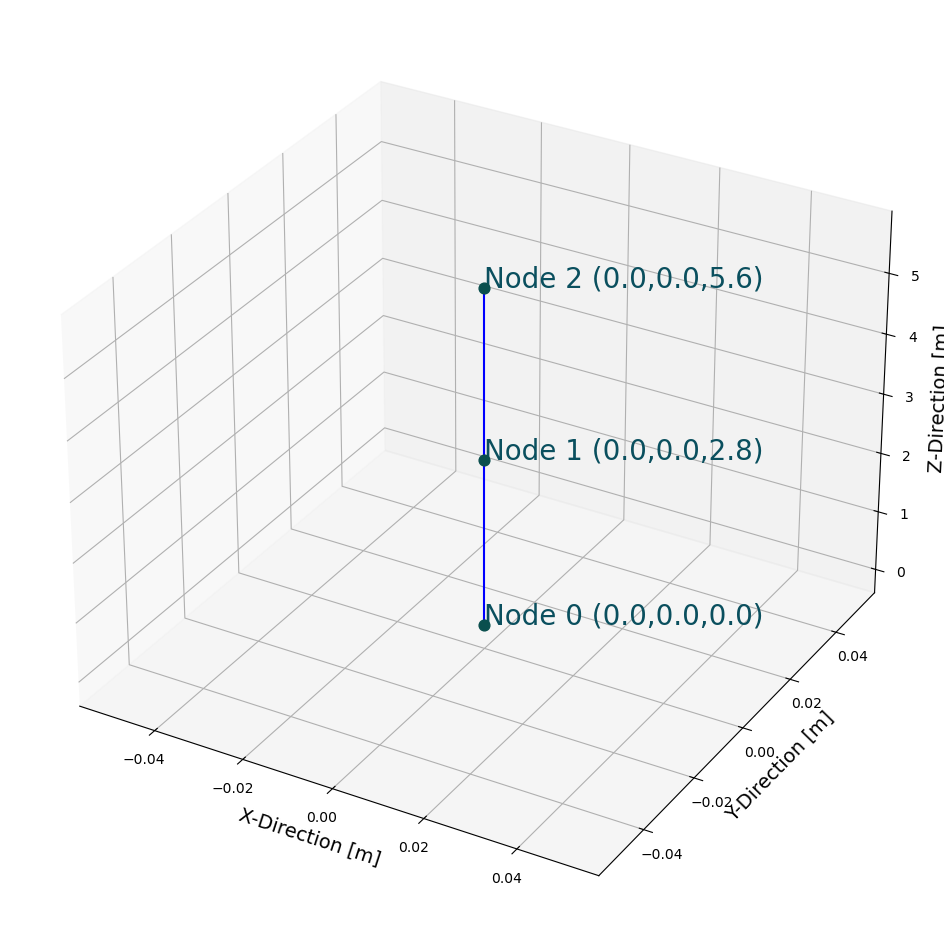

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 2 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 3 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 4 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 5 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 6 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 7 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 8 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 9 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 10 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 11 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 12 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 13 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 14 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 15 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 16 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 17 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 18 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 19 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 20 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 21 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 22 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 23 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 24 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 25 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 26 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 27 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 28 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 29 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 30 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 31 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 32 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 33 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 34 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 35 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 36 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 37 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 38 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 39 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 40 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 41 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 42 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 43 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 44 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 45 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 46 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 47 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 48 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 49 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 50 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 51 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 52 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 53 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 54 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 55 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 56 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 57 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 58 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 59 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 60 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 61 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 62 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 63 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 64 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 65 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 66 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 67 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 68 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 69 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 70 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 71 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 72 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 73 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 74 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 75 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 76 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 77 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 78 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 79 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 80 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 81 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 82 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 83 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 84 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 85 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 86 out of 200 ==================
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 87 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 88 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 89 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 90 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 91 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 92 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 93 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 94 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 95 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 96 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 97 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 98 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 99 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 100 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 101 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 102 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 103 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 104 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 105 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 106 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 107 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 108 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 109 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 110 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSING: 111 out of 200 ==================


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance


KeyboardInterrupt: 

In [27]:
# Loop over ground-motion records, compile MDOF model and run NLTHA
gmrs = sorted_alphanumeric(os.listdir(f'{gm_directory}/acc'))                         # Sort the ground-motion records alphanumerically
dts  = sorted_alphanumeric(os.listdir(f'{gm_directory}/dts'))                         # Sort the ground-motion time-step files alphanumerically

for i in range(len(gmrs)):
    ### Print post-processing iteration
    print('================================================================')
    print('============== ANALYSING: {:d} out of {:d} =================='.format(i+1, len(gmrs)))
    print('================================================================')

    ### Compile the MDOF model    
    model = modeller(number_storeys,floor_heights,floor_masses,storey_disps,storey_forces*units.g)    # Initialise the class (Build the model)
    model.compile_model()                                                                             # Compile the MDOF model
    if i==0:
        model.plot_model()                                                                            # Visualise the model (only on first iteration)
    model.do_gravity_analysis()                                                                       # Do gravity analysis

    if number_storeys == 1:
        num_modes = 1
    else:
        num_modes = 3
    T, _ = model.do_modal_analysis(num_modes = num_modes)                       # Do modal analysis and get period of vibration

    ### Define ground motion objects
    fnames = [f'{gm_directory}/acc/{gmrs[i]}']                                                   # Ground-motion record names
    fdts   =  f'{gm_directory}/dts/{dts[i]}'                                                     # Ground-motion time-step names 
    dt_gm = pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[1]-\
            pd.read_csv(fdts, header=None)[pd.read_csv(fdts,header=None).columns[0]].loc[0]      # Ground-motion time-step
    t_max = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].iloc[-1]                             # Ground-motion duration
    
    ### Define analysis params and do NLTHA
    dt_ansys = dt_gm                                                            # Set the analysis time-step
    sf = units.g                                                                # Set the scaling factor (if records are in g, a scaling factor of 9.81 m/s2 must be used to be consistent with opensees) 
    control_nodes, coll_index, peak_drift, peak_accel, max_peak_drift, max_peak_drift_dir, max_peak_drift_loc, max_peak_accel, max_peak_accel_dir, max_peak_accel_loc, peak_disp = model.do_nrha_analysis(fnames, 
                                                                                                                                                                                                          dt_gm, 
                                                                                                                                                                                                          sf, 
                                                                                                                                                                                                          t_max, 
                                                                                                                                                                                                          dt_ansys,
                                                                                                                                                                                                          temp_nrha_outdir,
                                                                                                                                                                                                          pflag=False,
                                                                                                                                                                                                          xi = sdof_damping)

    ### Store the analysis
    mdof_coll_index_list.append(coll_index)
    mdof_peak_drift_list.append(peak_drift)
    mdof_peak_accel_list.append(peak_accel)
    mdof_peak_disp_list.append(peak_disp)
    mdof_max_peak_drift_list.append(max_peak_drift)
    mdof_max_peak_drift_dir_list.append(max_peak_drift_dir)
    mdof_max_peak_drift_loc_list.append(max_peak_drift_loc)
    mdof_max_peak_accel_list.append(max_peak_accel)
    mdof_max_peak_accel_dir_list.append(max_peak_accel_dir)
    mdof_max_peak_accel_loc_list.append(max_peak_accel_loc)

print('ANALYSIS COMPLETED')

## Analysis Part 3: Export The Results

In [ ]:
# Store the analysis results in a dictionary
ansys_dict = {}
labels = ['T','control_nodes', 'mdof_coll_index_list',
          'mdof_peak_drift_list','mdof_peak_accel_list',
          'mdof_max_peak_drift_list', 'mdof_max_peak_drift_dir_list', 
          'mdof_max_peak_drift_loc_list','mdof_max_peak_accel_list',
          'mdof_max_peak_accel_dir_list','mdof_max_peak_accel_loc_list',
          'mdof_peak_disp_list']
for i, label in enumerate(labels):
    ansys_dict[label] = vars()[f'{label}']
# Export the analysis output variable to a pickle file using the "export_to_pkl" function from "utilities"
export_to_pkl(f'{nlthaOutDir}/ansys.pkl', ansys_dict) 

In [ ]:
end = time.time()
print('Elapsed Time:', (end - start)/60, 'minutes')